In [1]:
# Cell 1: Imports & Configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, subprocess

# Try to import yfinance; install if missing so notebook is self-contained
try:
    import yfinance as yf
except ImportError:
    print("yfinance not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance", "-q"])
    import yfinance as yf

# Fix random seed for reproducibility (important in Monte Carlo)
SEED = 42
rng = np.random.default_rng(SEED)

# Portfolio definition
tickers = ["SPY", "EFA", "IEMG", "AGG"]    # US equities, developed ex-US, EM equities, US bonds
weights = [0.50, 0.20, 0.15, 0.15]         # Portfolio weights (must sum to 1)

# Historical data window
start = "2015-01-01"
end = pd.Timestamp.today().strftime("%Y-%m-%d")

# Portfolio capital and horizon (here: 1-day VaR)
capital = 1_000_000.0
horizon_days = 1  

# Monte Carlo parameters
n_sims = 200_000
return_model = "log"  # choice: 'log' returns or 'arithmetic' returns

# Stress testing: adjust correlation structure if desired
target_offdiag_corr = 0.25
shock_strength = 1.0

# VaR confidence level
alpha = 0.95

# Wrap weights in a Series for label alignment
w = pd.Series(weights, index=tickers, dtype=float)
assert np.isclose(w.sum(), 1.0), "Weights must sum to 1."
print("Config OK — weights sum to 1 and are non-negative.")


Config OK — weights sum to 1 and are non-negative.


In [2]:
# Cell 2: Load price data
# By default this downloads adjusted close prices via yfinance
print("Downloading prices with yfinance...")
prices = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]

# Ensure column order matches tickers list and drop missing data
prices = prices[tickers].sort_index().dropna(how="any")

display(prices.tail())
print("Price data shape:", prices.shape)


Ticker,SPY,EFA,IEMG,AGG
Date,,,,
2025-09-26,661.820007,92.629997,65.190002,99.745583
2025-09-29,663.679993,92.989998,65.699997,99.934967
2025-09-30,666.179993,93.370003,65.919998,99.925003
2025-10-01,668.450012,94.139999,66.440002,100.180000
2025-10-02,669.219971,94.290001,66.750000,100.290001


Price data shape: (2704, 4)


In [3]:
# Cell 3: Compute daily returns
# Two common return definitions:
# - log returns (additive over time, useful for modeling)
# - arithmetic returns (actual % change, what P&L feels like)
log_rets = np.log(prices / prices.shift(1)).dropna()
arith_rets = prices.pct_change().dropna()

# Enforce consistent column order
log_rets = log_rets[tickers]
arith_rets = arith_rets[tickers]

print("Log/arithmetic return shapes:", log_rets.shape, arith_rets.shape)
display(log_rets.tail())


Log/arithmetic return shapes: (2703, 4) (2703, 4)


Ticker,SPY,EFA,IEMG,AGG
Date,,,,
2025-09-26,0.005713,0.007694,-0.002910,0.000700
2025-09-29,0.002806,0.003879,0.007793,0.001897
2025-09-30,0.003760,0.004078,0.003343,-0.000100
2025-10-01,0.003402,0.008213,0.007857,0.002549
2025-10-02,0.001151,0.001592,0.004655,0.001097


In [4]:
# Cell 4: Quick sanity checks
# Check annualized volatilities and correlation matrix
trading_days = 252
ann_vol_log = np.sqrt(np.diag(log_rets.cov().values) * trading_days)
ann_vol = pd.Series(ann_vol_log, index=log_rets.columns).sort_values(ascending=False)

print("Annualized vols (approx, from log-returns):")
display(ann_vol)

print("Correlation matrix:")
display(log_rets.corr())


Annualized vols (approx, from log-returns):


Ticker
IEMG    0.201052
SPY     0.179313
EFA     0.174145
AGG     0.052960
dtype: float64

Correlation matrix:


Ticker,SPY,EFA,IEMG,AGG
Ticker,,,,
SPY,1.000000,0.849570,0.762006,0.095807
EFA,0.849570,1.000000,0.840265,0.141298
IEMG,0.762006,0.840265,1.000000,0.113702
AGG,0.095807,0.141298,0.113702,1.000000


In [5]:
# Cell 5: Estimate mean and covariance
# Choice: log-return model (simulate in log space) or arithmetic-return model
if return_model == "log":
    mu = log_rets.mean() * horizon_days
    cov = log_rets.cov() * horizon_days
elif return_model == "arithmetic":
    mu = arith_rets.mean() * horizon_days
    cov = arith_rets.cov() * horizon_days
else:
    raise ValueError("return_model must be 'log' or 'arithmetic'")

print("Selected model:", return_model)
display(mu)
display(cov)


Selected model: log


Ticker
SPY     0.000505
EFA     0.000277
IEMG    0.000236
AGG     0.000071
dtype: float64

Ticker,SPY,EFA,IEMG,AGG
Ticker,,,,
SPY,0.000128,0.000105,0.000109,0.000004
EFA,0.000105,0.000120,0.000117,0.000005
IEMG,0.000109,0.000117,0.000160,0.000005
AGG,0.000004,0.000005,0.000005,0.000011


Simulated mean daily return: 0.000398
Simulated daily volatility : 0.009287
Monte Carlo VaR 95% (1-day): £14,803
Monte Carlo ES  95% (1-day): £18,615


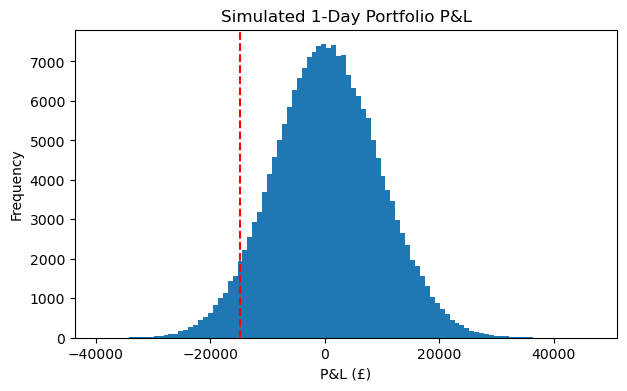

In [6]:
# Cell 6: Monte Carlo simulation of portfolio P&L
# 1. Draw random shocks with correct covariance via Cholesky
# 2. Convert to arithmetic returns if working in log space
# 3. Apply weights to get portfolio return distribution
L = np.linalg.cholesky(cov.values)
z = rng.standard_normal(size=(n_sims, len(tickers)))
shocks = z @ L.T + mu.values

if return_model == "log":
    sim_rets = np.exp(shocks) - 1.0
else:
    sim_rets = shocks

port_rets = sim_rets @ w.values
port_pnl = capital * port_rets

# Summary statistics
port_mean = port_rets.mean()
port_std = port_rets.std(ddof=1)

print(f"Simulated mean daily return: {port_mean:.6f}")
print(f"Simulated daily volatility : {port_std:.6f}")

# Compute Value-at-Risk and Expected Shortfall
q = np.quantile(port_pnl, 1 - alpha)
var_95 = -q
es_95 = -port_pnl[port_pnl <= q].mean()

print(f"Monte Carlo VaR {int(alpha*100)}% (1-day): £{var_95:,.0f}")
print(f"Monte Carlo ES  {int(alpha*100)}% (1-day): £{es_95:,.0f}")

# Plot simulated distribution
plt.figure(figsize=(7,4))
plt.hist(port_pnl, bins=100)
plt.axvline(-var_95, linestyle='--', color="red")
plt.title("Simulated 1-Day Portfolio P&L")
plt.xlabel("P&L (£)")
plt.ylabel("Frequency")
plt.show()


In [7]:
# Cell 7: Parametric (normal) VaR & simple backtest
# Uses historical mean and variance of arithmetic returns
mu_lin = arith_rets.mean() * horizon_days
cov_lin = arith_rets.cov() * horizon_days

port_mu_lin = float(mu_lin @ w)
port_sigma_lin = float(np.sqrt(w @ cov_lin @ w))

# Normal quantile without SciPy (using statistics.NormalDist)
from statistics import NormalDist
z_alpha = NormalDist().inv_cdf(alpha)

var_param = capital * (-(port_mu_lin) + z_alpha * port_sigma_lin)

print(f"Parametric VaR {int(alpha*100)}% (1-day, normal approx): £{var_param:,.0f}")

# Backtest: count how often realized loss < -VaR
hist_port_rets = (arith_rets @ w).dropna()
hist_port_pnl = capital * hist_port_rets
breaches = (hist_port_pnl < -var_param).sum()
total = len(hist_port_pnl)
breach_rate = breaches / total if total else np.nan
print(f"Backtest breaches: {breaches}/{total} ({breach_rate*100:.2f}%)")


Parametric VaR 95% (1-day, normal approx): £14,792
Backtest breaches: 107/2703 (3.96%)


In [8]:
# Cell 8: Correlation shock scenario
# Helper: replace correlations with a target value, keep variances
def shock_cov_to_offdiag_target(cov_in, target_rho, strength=1.0):
    std = np.sqrt(np.diag(cov_in.values))
    corr = cov_in.copy()
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            if i == j:
                corr.iat[i, j] = 1.0
            else:
                rho0 = cov_in.iloc[i, j] / (std[i] * std[j])
                corr.iat[i, j] = (1 - strength) * rho0 + strength * target_rho
    std_col = pd.Series(std, index=cov_in.index)
    shocked = corr.mul(std_col, axis=0).mul(std_col, axis=1)
    return shocked

if target_offdiag_corr is not None:
    shocked_cov = shock_cov_to_offdiag_target(cov, target_offdiag_corr, shock_strength)
    Ls = np.linalg.cholesky(shocked_cov.values)
    zs = rng.standard_normal(size=(n_sims, len(tickers)))
    shocks_s = zs @ Ls.T + mu.values
    sim_rets_s = np.exp(shocks_s) - 1.0 if return_model == "log" else shocks_s
    port_pnl_s = capital * (sim_rets_s @ w.values)
    q_s = np.quantile(port_pnl_s, 1 - alpha)
    var_s = -q_s
    print(f"Shocked-corr VaR (ρ={target_offdiag_corr:.2f}): £{var_s:,.0f}")
    print(f"Change vs baseline: £{(var_s - var_95):,.0f}")


Shocked-corr VaR (ρ=0.25): £11,885
Change vs baseline: £-2,918


In [9]:
# Cell 9: Extra robustness checks
# Sanity: check all objects are aligned
assert list(log_rets.columns) == tickers
assert list(arith_rets.columns) == tickers
assert list(mu.index) == tickers

demo_mu = float(mu @ w)
demo_var = float(w @ cov @ w)
print("Label-aligned demo mean/variance:", demo_mu, demo_var)

if target_offdiag_corr is not None and 'var_s' in locals():
    if (var_s - var_95) < 0:
        print("Warning: VaR decreased under higher correlation — unusual result.")
    else:
        print("Sanity: VaR increased with higher correlation, as expected.")


Label-aligned demo mean/variance: 0.00035375505134572826 8.60504007908502e-05


In [10]:
# Cell 10: Collect results in a dictionary
results = {
    "alpha": alpha,
    "capital": capital,
    "return_model": return_model,
    "n_sims": n_sims,
    "port_mean_1d": port_mean,
    "port_std_1d": port_std,
    "VaR_MC": float(var_95),
    "ES_MC": float(es_95),
    "VaR_parametric": float(var_param),
    "backtest_breaches": int(breaches),
    "backtest_total": int(total),
    "backtest_breach_rate": float(breach_rate),
}
if 'var_s' in locals():
    results["VaR_shocked_corr"] = float(var_s)
    results["VaR_shock_change"] = float(var_s - var_95)

results


{'alpha': 0.95,
 'capital': 1000000.0,
 'return_model': 'log',
 'n_sims': 200000,
 'port_mean_1d': 0.0003982211615907076,
 'port_std_1d': 0.009286783989110429,
 'VaR_MC': 14802.981727586792,
 'ES_MC': 18615.416163831032,
 'VaR_parametric': 14791.857209604523,
 'backtest_breaches': 107,
 'backtest_total': 2703,
 'backtest_breach_rate': 0.03958564557898631,
 'VaR_shocked_corr': 11884.53555640859,
 'VaR_shock_change': -2918.4461711782023}